- article about NN for chess move selection: https://www.chess.com/blog/the_real_greco/understanding-alphazero-a-basic-chess-neural-network
- For information about algorithmically implementing a transformer: https://arxiv.org/pdf/2207.09238.pdf
- Original Transformer article: https://arxiv.org/pdf/1706.03762.pdf
- Chess Transformers: https://github.com/sgrvinod/chess-transformers/tree/main
- Maia chess: https://arxiv.org/abs/2006.01855
- Leela Lc0: https://lczero.org/dev/backend/nn/
- Squeeze and Excitation paper: https://arxiv.org/abs/1709.01507
- AlphaZero paper: https://arxiv.org/pdf/1712.01815.pdf
- Consider Nucleus sampling for new agent strategy





TO DO:
- Create test-board scenarios with obvious answers for milestones
- use more recent data

Updates:


# Import Statements

In [10]:
import chess

import chess.svg
import cv2
from IPython.display import display, SVG

import numpy as np
import random
from tqdm import tqdm
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import utils
reload(utils)
import utils

In [2]:
if torch.cuda.is_available():
    # Set default tensor type to CUDA tensors
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    
else:
    
    torch.set_default_tensor_type(torch.FloatTensor)
 
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

False


# Importing Game Data:
- PGN loading documentation: https://python-chess.readthedocs.io/en/latest/pgn.html

In [3]:
output_file = 'Data/lichess_db_standard_rated_2015-08.pgn'
#decompress_zst(input_file, output_file)

In [11]:
boards, meta, _, moves, pieces, _ = generate_data(output_file, N = 20_000, get_attacks=False)

0it [00:00, ?it/s]
100%|██████████| 20000/20000 [03:09<00:00, 105.55it/s]


# Playing Agents:

# Chapter 2
## RDv1.1
Deterministic: ROWR 0.69 


Probabilistic: ROWR 0.92 


Deterministic vs Probabilistic: 0.97 (prob)

## RDv2.0
Deterministic: ROWR 0.72

Prob: ROWR 93.6

Prob vs Det: .95 : 0.05

v2Prob vs v1Prob: .95 : .05

# RDv2.1
95.0 ROWR

2.1 vs 2.0: 360-30-110
2.1.1 vs 2.0: 370-22-108

In [4]:
class MLPv2_1(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')
        
        self.layers = nn.ModuleList()
        
        self.depth = 6
        
        for _ in range(self.depth):
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 128)

    def forward(self, x):

        x = self.conv1(x)
        
        for i in range(self.depth):
            j = i*4
            ph = x.clone()
            ph = self.layers[j](ph)
            ph = self.layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.layers[j+2](ph)
            ph = self.layers[j+3](ph)
            
            x = x + ph
            x = F.relu(x)
                  
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.linear(x)
        
        minn, ila = x[:,:64], x[:,64:]

        return minn, ila

In [11]:
RDv2_1 = MLPv2_1()
RDv2_1 = RDv2_1.to(device)

criterion = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()

optimizer = optim.SGD(RDv2_1.parameters(), lr = 0.01, momentum=0.9)
B = 128

loader = DataLoader(ChessDataConv(boards, meta, moves), batch_size = B, shuffle = True, generator=torch.Generator(device='cuda'))

NameError: name 'boards' is not defined

In [15]:
losses = []

G = len(loader)

for epoch in range(20):

    running_loss = 0

    for bitboards, target in tqdm(loader):

        optimizer.zero_grad()

        minn, ila = RDv2_1(bitboards)

        loss = criterion(minn, target[:,:64]) + criterion2(ila, target[:,64:])

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
    running_loss /= G
    
    losses.append(running_loss)
    print(f'Finished epoch {epoch+1} with loss {running_loss:.4f}')
    if epoch % 5 == 4:
        torch.save(RDv2_1,f"RDv2.1 3M' {G*B*(epoch+1)}iters.pt")
        print(f"Baseline against RDv2.0: {test_against(lambda x: network_agent_prob_conv(x, RDv2_1, with_attacks=True), lambda x: network_agent_prob_conv(x, RDv2_1_0, with_attacks=True),N=50)}")
        
    
    if epoch > 3 and losses[-1] > losses[-2]:
        break
        

print('Finished Training')

100%|██████████| 21975/21975 [02:57<00:00, 123.73it/s]


Finished epoch 1 with loss 3.9564


100%|██████████| 21975/21975 [02:55<00:00, 125.26it/s]


Finished epoch 2 with loss 3.1879


100%|██████████| 21975/21975 [02:55<00:00, 124.93it/s]


Finished epoch 3 with loss 2.9988


100%|██████████| 21975/21975 [02:55<00:00, 125.16it/s]


Finished epoch 4 with loss 2.8910


100%|██████████| 21975/21975 [02:56<00:00, 124.82it/s]


Finished epoch 5 with loss 2.8185


100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Baseline against RDv2.0: (17, 12, 21, 0.34)


100%|██████████| 21975/21975 [02:55<00:00, 125.10it/s]


Finished epoch 6 with loss 2.7651


100%|██████████| 21975/21975 [02:57<00:00, 123.94it/s]


Finished epoch 7 with loss 2.7230


100%|██████████| 21975/21975 [02:57<00:00, 123.74it/s]


Finished epoch 8 with loss 2.6893


100%|██████████| 21975/21975 [02:57<00:00, 123.59it/s]


Finished epoch 9 with loss 2.6610


100%|██████████| 21975/21975 [02:57<00:00, 123.92it/s]


Finished epoch 10 with loss 2.6364


100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


Baseline against RDv2.0: (12, 9, 29, 0.24)


100%|██████████| 21975/21975 [02:56<00:00, 124.21it/s]


Finished epoch 11 with loss 2.6147


100%|██████████| 21975/21975 [02:55<00:00, 125.16it/s]


Finished epoch 12 with loss 2.5961


100%|██████████| 21975/21975 [02:58<00:00, 123.03it/s]


Finished epoch 13 with loss 2.5791


100%|██████████| 21975/21975 [03:01<00:00, 121.20it/s]


Finished epoch 14 with loss 2.5637


100%|██████████| 21975/21975 [03:02<00:00, 120.12it/s]


Finished epoch 15 with loss 2.5498


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Baseline against RDv2.0: (17, 10, 23, 0.34)


100%|██████████| 21975/21975 [03:04<00:00, 119.32it/s]


Finished epoch 16 with loss 2.5371


 20%|█▉        | 4356/21975 [00:37<02:29, 118.04it/s]

In [16]:
test_against(RDv2_1_agent, N=500)

100%|██████████| 250/250 [00:40<00:00,  6.15it/s]


(489, 0, 11, 0.978)

In [ ]:
def RDv2_1_agent(board):

    return network_agent_prob_conv(board, RDv2_1, with_attacks=True)

In [14]:
RDv2_2 = torch.load("RDv2.2 3M 20eps.pt", map_location=device)

In [5]:
RDv2_3 = torch.load("Models/RDv2.3 CB.pt", map_location=device)

In [56]:
RDv2_1 = torch.load("Models/RDv2.1.1 3M.pt", map_location=device)

In [15]:
RDv2_1_0 = torch.load("Models/RDv2.1 600k.pt")

AttributeError: Can't get attribute 'MLPv2_1' on <module '__main__'>

In [59]:
test_against(RDv2_agent_prob, RDv2_agent)

100%|██████████| 250/250 [02:27<00:00,  1.69it/s]


(171, 40, 289, 0.342)

# Mega Training Loop

In [94]:
import gc
    
loops = 3
start = 0

losses = []

RDv2_3 = torch.load("Models/RDv2.3 CB.pt", map_location=device)

criterion = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()

optimizer = optim.SGD(RDv2_3.parameters(), lr = 0.001, momentum=0.9)
B = 1024

for i in range(start,loops + start):

    boards, meta, _, moves = load_from_csv("Data/lichess_games.csv", N = 1_000_000, skip=1_000_000 * i)
    
    loader = DataLoader(ChessDataConv(boards, meta, moves), batch_size = B, shuffle = True, generator=torch.Generator(device='cuda'))
    
    G = len(loader)

    for epoch in range(15):

        running_loss = 0

        for bitboards, target in loader:

            optimizer.zero_grad()

            minn, ila = RDv2_3(bitboards)

            loss = criterion(minn, target[:,:64]) + criterion2(ila, target[:,64:])

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        running_loss /= G

        losses.append(running_loss)
        print(f'Finished epoch {epoch+1} with loss {running_loss:.4f}')


        if epoch > 3 and losses[-1] > losses[-2]:
            break
            
    torch.save(RDv2_3,f"RDv2.3 {i} loops.pt")
            
    compete = test_against(lambda x: network_agent_prob_conv(x, RDv2_3, with_attacks=True), \
                           lambda x: network_agent_prob_conv(x, RDv2_1, with_attacks=True),N=50)
    print(f"Baseline against RDv2.1: {compete}")
    
    del loader, boards, meta, moves

    # Clean up GPU memory
    torch.cuda.empty_cache()
    gc.collect()


print('Finished Training')

100%|█████████▉| 999999/1000000 [06:17<00:00, 2646.11it/s]


Finished epoch 1 with loss 2.7542
Finished epoch 2 with loss 2.7157
Finished epoch 3 with loss 2.7006
Finished epoch 4 with loss 2.6907
Finished epoch 5 with loss 2.6829
Finished epoch 6 with loss 2.6765
Finished epoch 7 with loss 2.6709
Finished epoch 8 with loss 2.6660
Finished epoch 9 with loss 2.6614
Finished epoch 10 with loss 2.6571
Finished epoch 11 with loss 2.6532
Finished epoch 12 with loss 2.6496
Finished epoch 13 with loss 2.6462
Finished epoch 14 with loss 2.6429
Finished epoch 15 with loss 2.6398


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Baseline against RDv2.1: (22, 7, 21, 0.44)


 69%|██████▉   | 692246/1000000 [04:27<01:59, 2584.65it/s]


KeyboardInterrupt: 

In [95]:
test_against(lambda x: network_agent_prob_conv(x, RDv2_3, with_attacks=True), \
           lambda x: network_agent_prob_conv(x, RDv2_1, with_attacks=True), N= 250)

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


(90, 58, 102, 0.36)

In [6]:
model = lambda x: network_agent_prob_conv(x, RDv2_3)

puzzles = generate_puzzles(N_puzzles=1_000, first_move=False)

puzzles = shuffle_puzzles(puzzles)

In [9]:
evaluate_on_puzzles(model, puzzles, 3000)

(0.266, 1725)

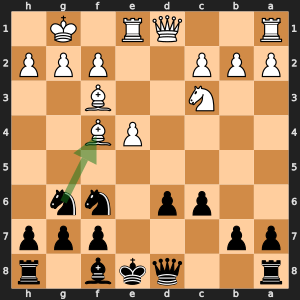

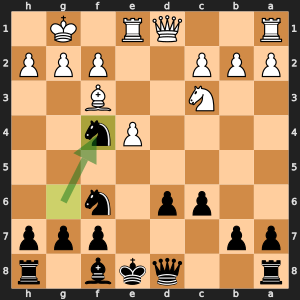

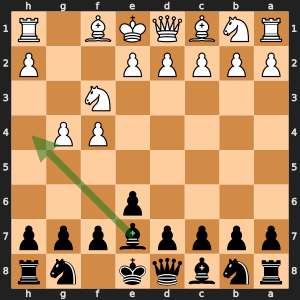

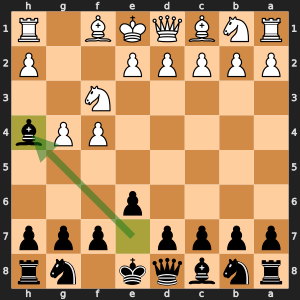

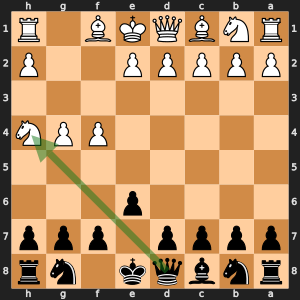

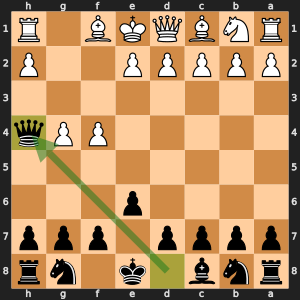

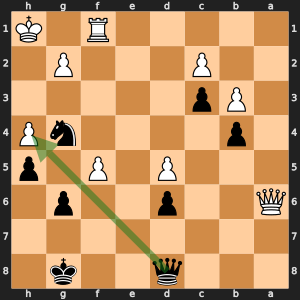

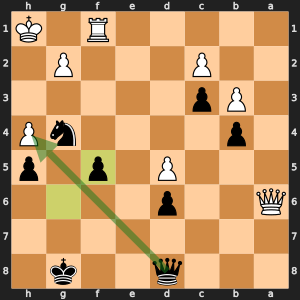

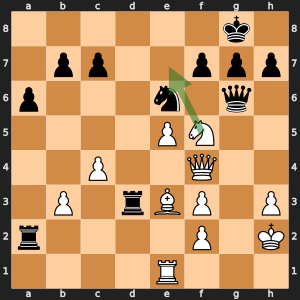

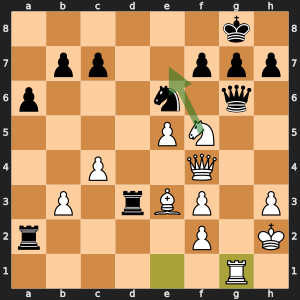

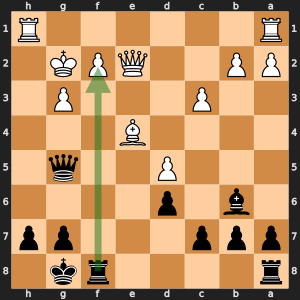

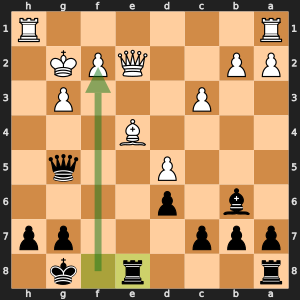

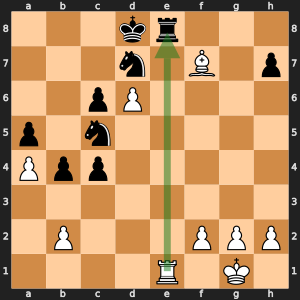

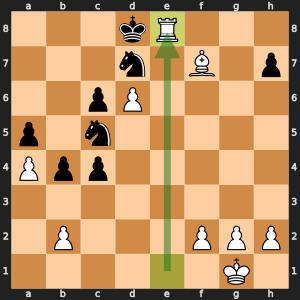

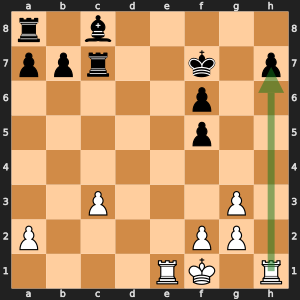

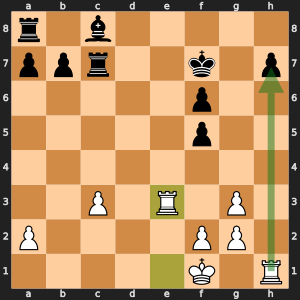

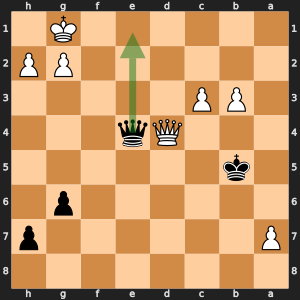

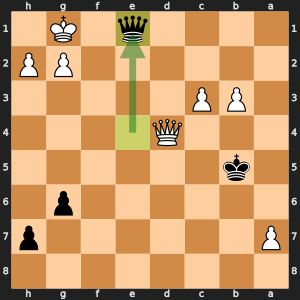

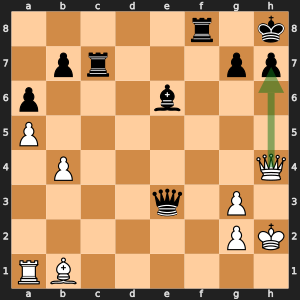

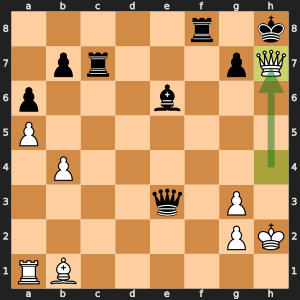

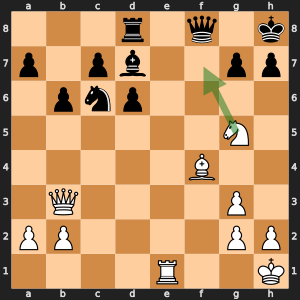

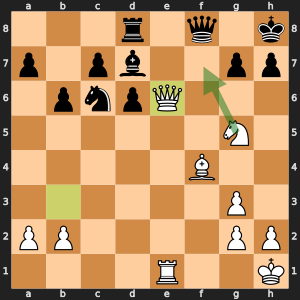

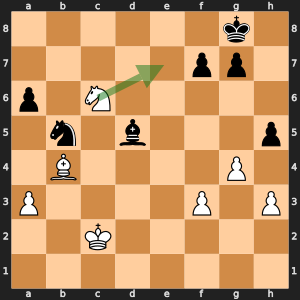

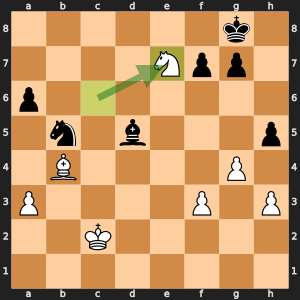

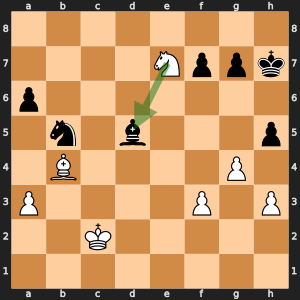

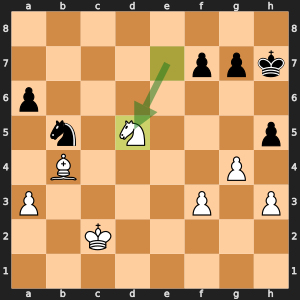

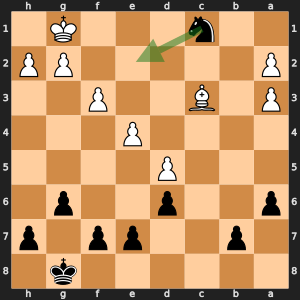

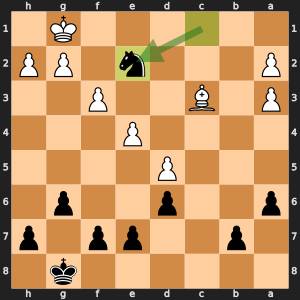

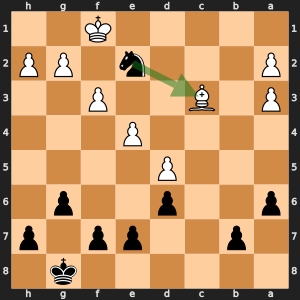

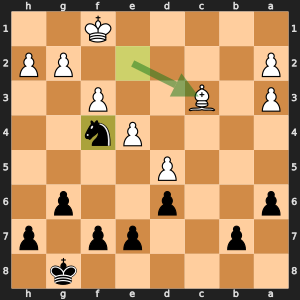

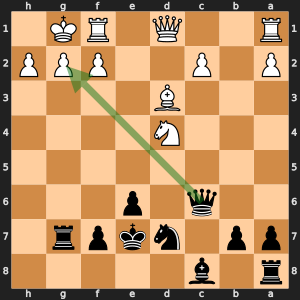

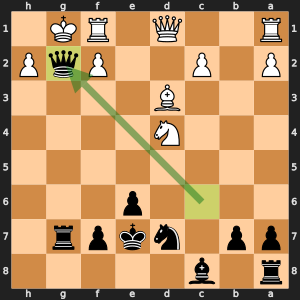

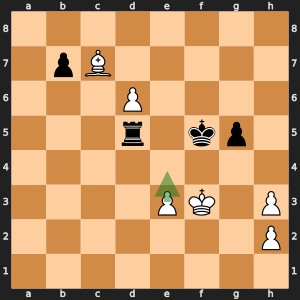

KeyboardInterrupt: Interrupted by user

In [7]:
visualize_puzzles(model, puzzles, 1000)

# RDv2.2

In [11]:
class MLPv2_2(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')
        
        self.layers = nn.ModuleList()
        
        self.depth = 6
        
        for _ in range(self.depth):
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 4096)

    def forward(self, x):

        x = self.conv1(x)
        
        for i in range(self.depth):
            j = i*4
            ph = x.clone()
            ph = self.layers[j](ph)
            ph = self.layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.layers[j+2](ph)
            ph = self.layers[j+3](ph)
            
            x = x + ph
            x = F.relu(x)
                  
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.linear(x)

        return x

In [25]:
#RDv2_2 = MLPv2_2().to(device)
RDv2_2 = torch.load("RDv2.2 3M 15eps.pt", map_location=device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(RDv2_2.parameters(), lr = 0.01, momentum=0.9)
B = 128

loader = DataLoader(ChessDataConvExhaustive(boards, meta, moves), batch_size = B, shuffle = True, generator=torch.Generator(device='cuda'))

In [26]:
losses = []

G = len(loader)

for epoch in range(20):

    running_loss = 0

    for bitboards, target in tqdm(loader):

        optimizer.zero_grad()

        output = RDv2_2(bitboards)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
    running_loss /= G
    
    losses.append(running_loss)
    print(f'Finished epoch {epoch+1} with loss {running_loss:.4f}')
    if epoch % 5 == 4:
        torch.save(RDv2_2,f"RDv2.2 3M {epoch+1}eps.pt")
        compete = test_against(lambda x: network_agent_prob_conv_exhaustive(x, RDv2_2), \
                               lambda x: network_agent_prob_conv(x, RDv2_1, with_attacks=True),N=50)
        print(f"Baseline against RDv2.1: {compete}")
        
    
    if epoch > 3 and losses[-1] > losses[-2]:
        break
        

print('Finished Training')

100%|██████████| 21978/21978 [04:50<00:00, 75.73it/s]


Finished epoch 1 with loss 1.1183


100%|██████████| 21978/21978 [04:27<00:00, 82.27it/s]


Finished epoch 2 with loss 1.1026


100%|██████████| 21978/21978 [04:26<00:00, 82.43it/s]


Finished epoch 3 with loss 1.0878


100%|██████████| 21978/21978 [04:26<00:00, 82.60it/s]


Finished epoch 4 with loss 1.0750


100%|██████████| 21978/21978 [04:26<00:00, 82.57it/s]


Finished epoch 5 with loss 1.0622


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Baseline against RDv2.1: (7, 24, 19, 0.14)


100%|██████████| 21978/21978 [04:27<00:00, 82.28it/s]


Finished epoch 6 with loss 1.0501


100%|██████████| 21978/21978 [04:27<00:00, 82.07it/s]


Finished epoch 7 with loss 1.0389


100%|██████████| 21978/21978 [04:27<00:00, 82.21it/s]


Finished epoch 8 with loss 1.0277


100%|██████████| 21978/21978 [04:27<00:00, 82.23it/s]


Finished epoch 9 with loss 1.0175


100%|██████████| 21978/21978 [04:27<00:00, 82.21it/s]


Finished epoch 10 with loss 1.0080


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Baseline against RDv2.1: (12, 24, 14, 0.24)


100%|██████████| 21978/21978 [04:27<00:00, 82.24it/s]


Finished epoch 11 with loss 0.9990


100%|██████████| 21978/21978 [04:26<00:00, 82.32it/s]


Finished epoch 12 with loss 0.9900


100%|██████████| 21978/21978 [04:26<00:00, 82.37it/s]


Finished epoch 13 with loss 0.9816


100%|██████████| 21978/21978 [04:26<00:00, 82.36it/s]


Finished epoch 14 with loss 0.9736


100%|██████████| 21978/21978 [04:28<00:00, 81.85it/s]


Finished epoch 15 with loss 0.9658


100%|██████████| 25/25 [00:11<00:00,  2.22it/s]


Baseline against RDv2.1: (12, 26, 12, 0.24)


100%|██████████| 21978/21978 [04:28<00:00, 81.72it/s]


Finished epoch 16 with loss 0.9583


100%|██████████| 21978/21978 [04:28<00:00, 81.72it/s]


Finished epoch 17 with loss 0.9509


100%|██████████| 21978/21978 [04:28<00:00, 81.77it/s]


Finished epoch 18 with loss 0.9443


100%|██████████| 21978/21978 [04:28<00:00, 81.78it/s]


Finished epoch 19 with loss 0.9374


100%|██████████| 21978/21978 [04:28<00:00, 81.98it/s]


Finished epoch 20 with loss 0.9312


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

Baseline against RDv2.1: (10, 24, 16, 0.2)
Finished Training


## RDv4.0

In [82]:
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.positional_encoding = nn.Parameter(torch.zeros((1,64,12)))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=12, nhead=4), num_layers=4)
        self.fc = nn.Linear(768, 128)
        
    def forward(self, x):

        x = x + self.positional_encoding.repeat(x.size(0), 1, 1)
        x = self.transformer(x)
        x = x.view(-1, 768)
        x = self.fc(x)
        
        minn = x[:,:64]
        ila = x[:,64:]

        return minn, ila
    

In [83]:
RDv4 = TransformerModel().to(device)

criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
B = 64
loader = DataLoader(ChessData(boards, meta, moves), batch_size = B, shuffle = True,
                   generator=torch.Generator(device='cuda'))

In [86]:
losses = []

G = len(loader)

for epoch in range(20):

    running_loss = 0

    for bitboards, target in tqdm(loader):

        optimizer.zero_grad()
        
        bitboards = bitboards.view(-1,64,12).to(torch.int)

        minn, ila = RDv4(bitboards)

        loss = criterion1(minn, target[:,:64]) + criterion2(ila, target[:,64:])

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
    running_loss /= G
    
    losses.append(running_loss)
    print(f'Finished epoch {epoch+1} with loss {running_loss:.4f}')
    """
    if epoch % 5 == 4:
        torch.save(RDv4,f"RDv4 1.2M {epoch+1}eps.pt")
        compete = test_against(lambda x: network_agent_prob_conv_exhaustive(x, RDv4), \
                               lambda x: network_agent_prob_conv(x, RDv2_1, with_attacks=True),N=50)
        print(f"Baseline against RDv2.1: {compete}")
        
    
    if epoch > 3 and losses[-1] > losses[-2]:
        break"""
        

print('Finished Training')

100%|██████████| 17451/17451 [01:52<00:00, 155.68it/s]


Finished epoch 1 with loss 8.6147


100%|██████████| 17451/17451 [01:52<00:00, 155.61it/s]


Finished epoch 2 with loss 8.6140


100%|██████████| 17451/17451 [01:52<00:00, 155.64it/s]


Finished epoch 3 with loss 8.6144


  8%|▊         | 1330/17451 [00:08<01:43, 155.41it/s]


KeyboardInterrupt: 

In [113]:
def transformer_agent(board):
    return network_agent_prob(board, model)

In [ ]:
test_against(transformer_agent, random_agent)

# Clear cuda cache stuff

In [14]:
import gc

# Clean up GPU memory
torch.cuda.empty_cache()
gc.collect()

1395

In [24]:
import torch

# Function to print active variables on CUDA
def print_cuda_variables():
    print("Active variables on CUDA:")
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            if obj.is_cuda:
                print(type(obj), obj.size(), obj.device)
                del obj

# Call the function to print active variables on CUDA
print_cuda_variables()


Active variables on CUDA:
<class 'torch.Tensor'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([4096]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([4096, 4096]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3]) cuda:0
<clas

In [22]:
del loader